In [31]:
# this code can read data and metadata in 384-well format and do the math
# it also asks the user for the name of the data and metadata file names and names the output files accordingly
# this is basically a cleaned up version of v3.0
# + v3.2 can accept a whole input folder of .csv files.
# v3.3 shows bar plot + scatter plot that also marks edge wells red
# unfortunately, some comments got lost after modification by ChatGPT



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def create_folder():
    input_path = os.getcwd() + "/"
    folder_path = input_path + "output/"
    if not os.path.exists(folder_path):
        output_folder = os.makedirs(folder_path)
        print(f"Folder created at {folder_path}")
    else:
        print(f"Folder already exists at {folder_path}")
    return folder_path, input_path

def datafiles(input_path):
    # Get all CSV files in the specified folder excluding metadata.csv
    csv_files = [file for file in os.listdir(input_path) if file.endswith('.csv') and file != 'metadata.csv']
    return csv_files

def detect_delimiter(file_path):
    with open(file_path, 'r') as file: # 'r' = read-only; 
        # Read the first few lines to detect the delimiter
        sample_lines = [file.readline() for _ in range(5)]
        # Once the code block is exited (either normally or due to an exception), the with statement ensures that the file is closed, releasing any system resources associated with it
    if any(',' in line for line in sample_lines):
        return ','
    elif any(';' in line for line in sample_lines):
        return ';'

def prepare_data(data_input):
    delimiter = detect_delimiter(data_input)
    data = pd.read_csv(data_input, sep=delimiter, index_col=0)
    data_T = data.T
    data_T = data_T.reset_index()
    data_T = data_T.rename(columns={'index': 'well'})
    data_T_melt = pd.melt(data_T, id_vars=['well'], var_name='OD')
    data_T_melt['well'] = data_T_melt['OD'] + data_T_melt['well']
    data_T_melt = data_T_melt[['well', 'value']]
    data_T_melt = data_T_melt.rename(columns={'value': 'OD'})
    print(f"Quality control of transformed data ({data_input}):\n")
    print(data_T_melt)
    return data_T_melt, data

def prepare_metadata(metadata_input):
    delimiter = detect_delimiter(metadata_input)
    metadata = pd.read_csv(metadata_input, sep=',', index_col=0)
    metadata_T = metadata.T
    meatadata_T = metadata_T.reset_index()
    metadata_T = meatadata_T.rename(columns={'index': 'well'})
    metadata_T_melt = pd.melt(metadata_T, id_vars=['well'], var_name='condition')
    metadata_T_melt['well'] = metadata_T_melt['condition'] + metadata_T_melt['well']
    metadata_T_melt = metadata_T_melt[['well', 'value']]
    metadata_T_melt = metadata_T_melt.rename(columns={'value': 'condition'})
    print(f"Quality control of transformed metadata ({metadata_input}):\n")
    print(metadata_T_melt)
    return metadata_T_melt

def merge(data, metadata, folder, data_name):
    merged_data = pd.merge(data, metadata, on='well')
    #merged_data = merged_data.drop("well", axis=1)
    merged_data = merged_data.sort_values(by='condition', ascending=False)
    merged_data.to_csv(os.path.join(folder, f'{data_name}_merged_data.csv'), index=False)
    print(f"Quality control of merged data ({data_name}_merged_data.csv):\n")
    print(merged_data)
    print(f"Saved at: {os.path.join(folder)}")
    return merged_data

def group_data(data_merged, folder, data_name):
    grouped_data = data_merged.groupby('condition').agg({'OD': ['mean', 'std']})
    grouped_data.reset_index(inplace=True)
    grouped_data.columns = ['condition', 'mean_OD', 'std_OD']
    grouped_data.to_csv(os.path.join(folder, f'{data_name}_grouped_data.csv'), index=False)
    print(f"Quality control of grouped data ({data_name}_grouped_data.csv):\n")
    print(f"Saved at: {os.path.join(folder)}")
    print("Quality control of mean and std. (grouped_data):\n")
    print(grouped_data)
    return grouped_data

def plot_BarGraph(data_merged, folder_path, data_name, fig_size_bar, dpi):
    col_one = ('B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'O1')
    # Determine if a well is at the edge
    data_merged['edge_well'] = data_merged['well'].apply(lambda x: x.startswith('A') or x.startswith('P') or x.endswith('24') or x == col_one)

    # Create a figure with the specified size
    plt.figure(figsize=fig_size_bar)

    # Use Seaborn's barplot to create the bar graph with error bars
    sns.barplot(x="condition", y="OD", data=data_merged, capsize=.1, errorbar='sd')

    # Use Seaborn's swarmplot to add swarm plot points
    sns.swarmplot(x="condition", y="OD", data=data_merged, hue="edge_well", palette={False: '0', True: 'red'}, alpha=.35, size=4)

    # Show the plot
    plt.savefig(os.path.join(folder_path, f'{data_name}_bar-graph.png'), dpi=dpi)
    plt.show()

def generate_heatmap(data, folder_path, data_name, fig_size_heat, dpi):
    plt.figure(figsize=fig_size_heat)
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True, square=False)
    plt.title(f'{data_name}_Plate Heatmap')
    plt.savefig(os.path.join(folder_path, f'{data_name}_heat-map.png'), dpi=dpi)
    plt.show()

def main():
    fig_size_bar = (10, 20)
    fig_size_heat = (20, 10)
    dpi = 400
    folder_path, input_path = create_folder()
    csv_files = datafiles(input_path)

    for csv_file in csv_files:
        data_T_melt, data = prepare_data(os.path.join(input_path, csv_file))
        metadata_T_melt = prepare_metadata(os.path.join(input_path, 'metadata.csv'))  # Assuming metadata.csv is fixed
        merged_data = merge(data_T_melt, metadata_T_melt, folder_path, csv_file[:-4])
        grouped_data = group_data(merged_data, folder_path, csv_file[:-4])
        plot_BarGraph(merged_data, folder_path, csv_file[:-4], fig_size_bar, dpi)
        generate_heatmap(data, folder_path, csv_file[:-4], fig_size_heat, dpi)


In [32]:
# now calculate a z-score
# the .loc function extracts the value from the table at the crossing point of the descriptors
# the .iloc function lets you do the same, but based on integer row and column positions (e.g. 0, 3)
# df.iloc[row_position, column_position], keep in mind that the df is zero-indexed
# this is still very hard coded and does not work for > 2 conditions...
  #  mean_neg = grouped_data.iloc[1, 1]
  #  mean_pos = grouped_data.iloc[0, 1]
  #  std_neg = grouped_data.iloc[1, 2]
  #  std_pos = grouped_data.iloc[0, 2]
  #  z = 1 - (3*(std_pos+std_neg))/(mean_pos-mean_neg)
  #  print(z)
  #  grouped_data.to_csv(os.path.join(folder_path + data_name + '_statistics_data.csv'), index=False)

Folder already exists at /Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.3_test/output/
Quality control of transformed data (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.3_test/231115_E-coli_wellmate_endpoint-19h.csv):

    well     OD
0     A1  0.917
1     A2  0.964
2     A3  0.987
3     A4  0.960
4     A5  0.949
..   ...    ...
379  P20  0.093
380  P21  0.086
381  P22  0.086
382  P23  0.111
383  P24  0.147

[384 rows x 2 columns]
Quality control of transformed metadata (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.3_test/metadata.csv):

    well                  condition
0     A1                DMSO, EC wt
1     A2                DMSO, EC wt
2     A3                DMSO, EC wt
3     A4                DMSO, EC wt
4     A5                DMSO, EC wt
..   ...                        ...
379  P20  1.33 µg/mL cipro, EC perm
380  P21  1.33 µg

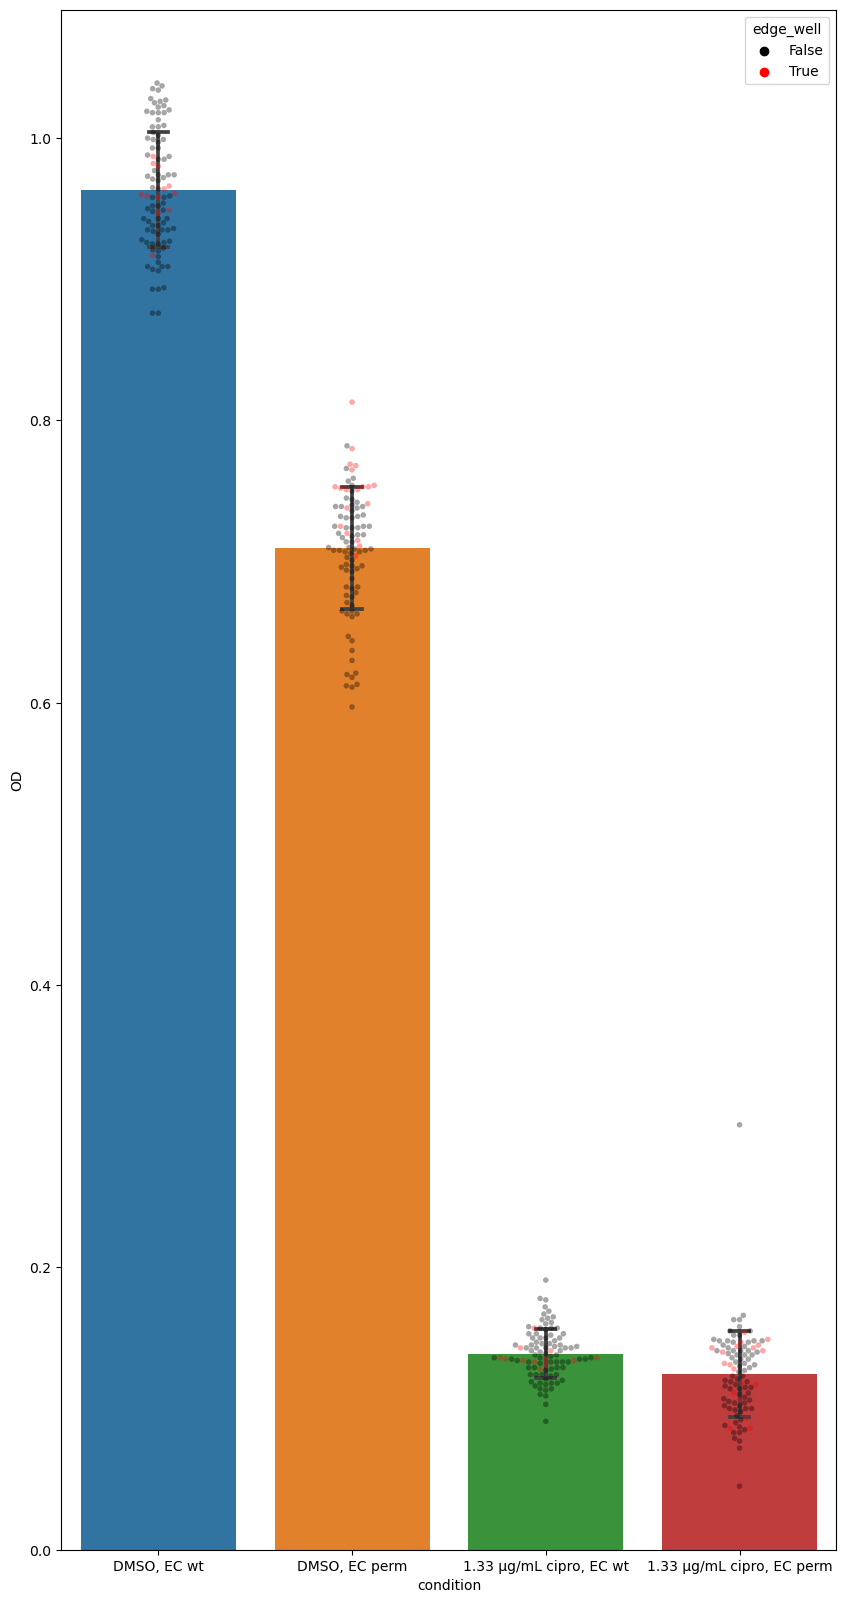

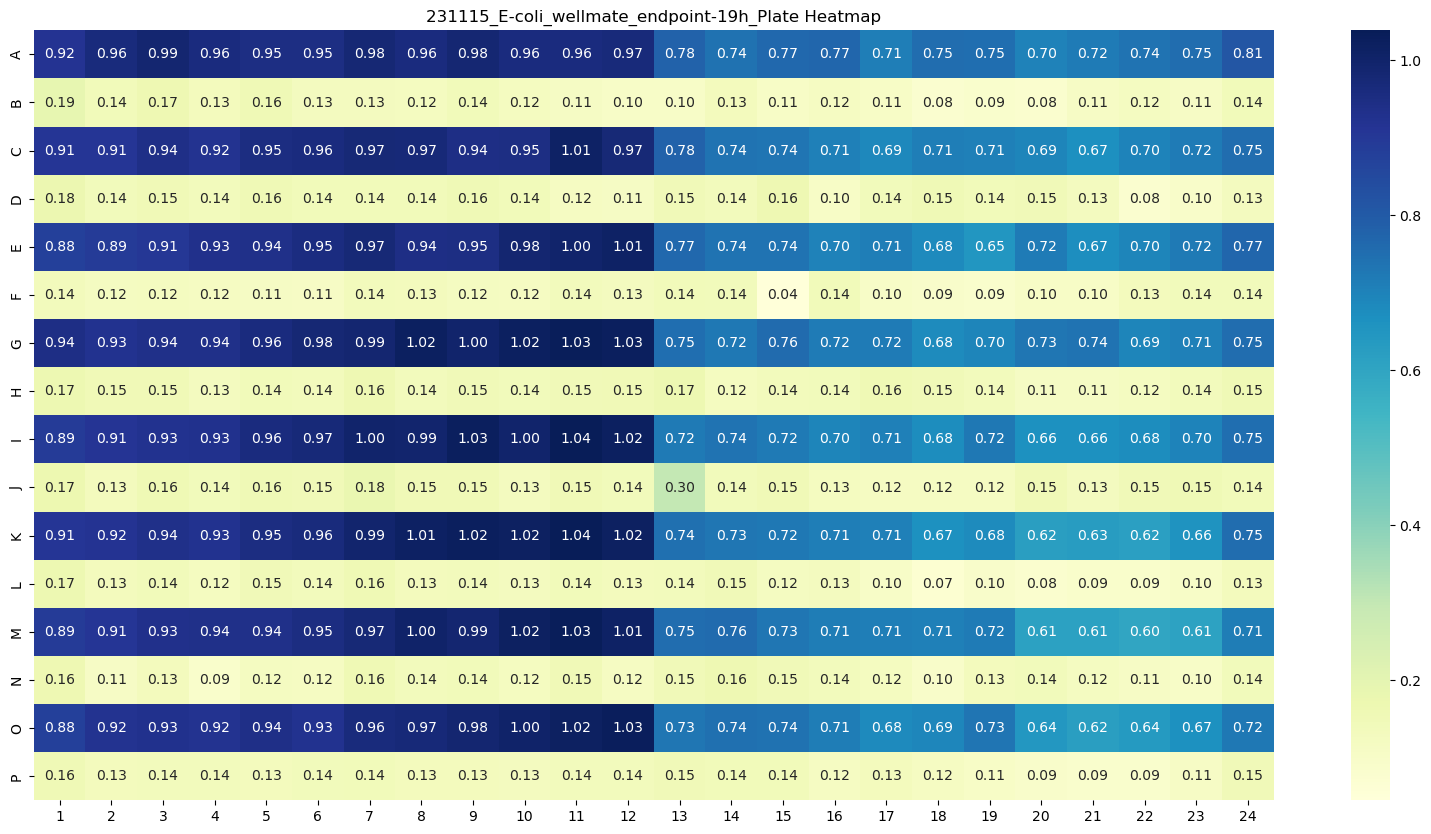

Quality control of transformed data (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.3_test/231115_E-coli_wellmate_endpoint-24h.csv):

    well     OD
0     A1  0.920
1     A2  0.925
2     A3  0.937
3     A4  0.945
4     A5  0.914
..   ...    ...
379  P20  0.072
380  P21  0.063
381  P22  0.061
382  P23  0.086
383  P24  0.112

[384 rows x 2 columns]
Quality control of transformed metadata (/Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.3_test/metadata.csv):

    well                  condition
0     A1                DMSO, EC wt
1     A2                DMSO, EC wt
2     A3                DMSO, EC wt
3     A4                DMSO, EC wt
4     A5                DMSO, EC wt
..   ...                        ...
379  P20  1.33 µg/mL cipro, EC perm
380  P21  1.33 µg/mL cipro, EC perm
381  P22  1.33 µg/mL cipro, EC perm
382  P23  1.33 µg/mL cipro, EC perm
383  P24  1.33 µg/mL cipro, EC perm

[384 row

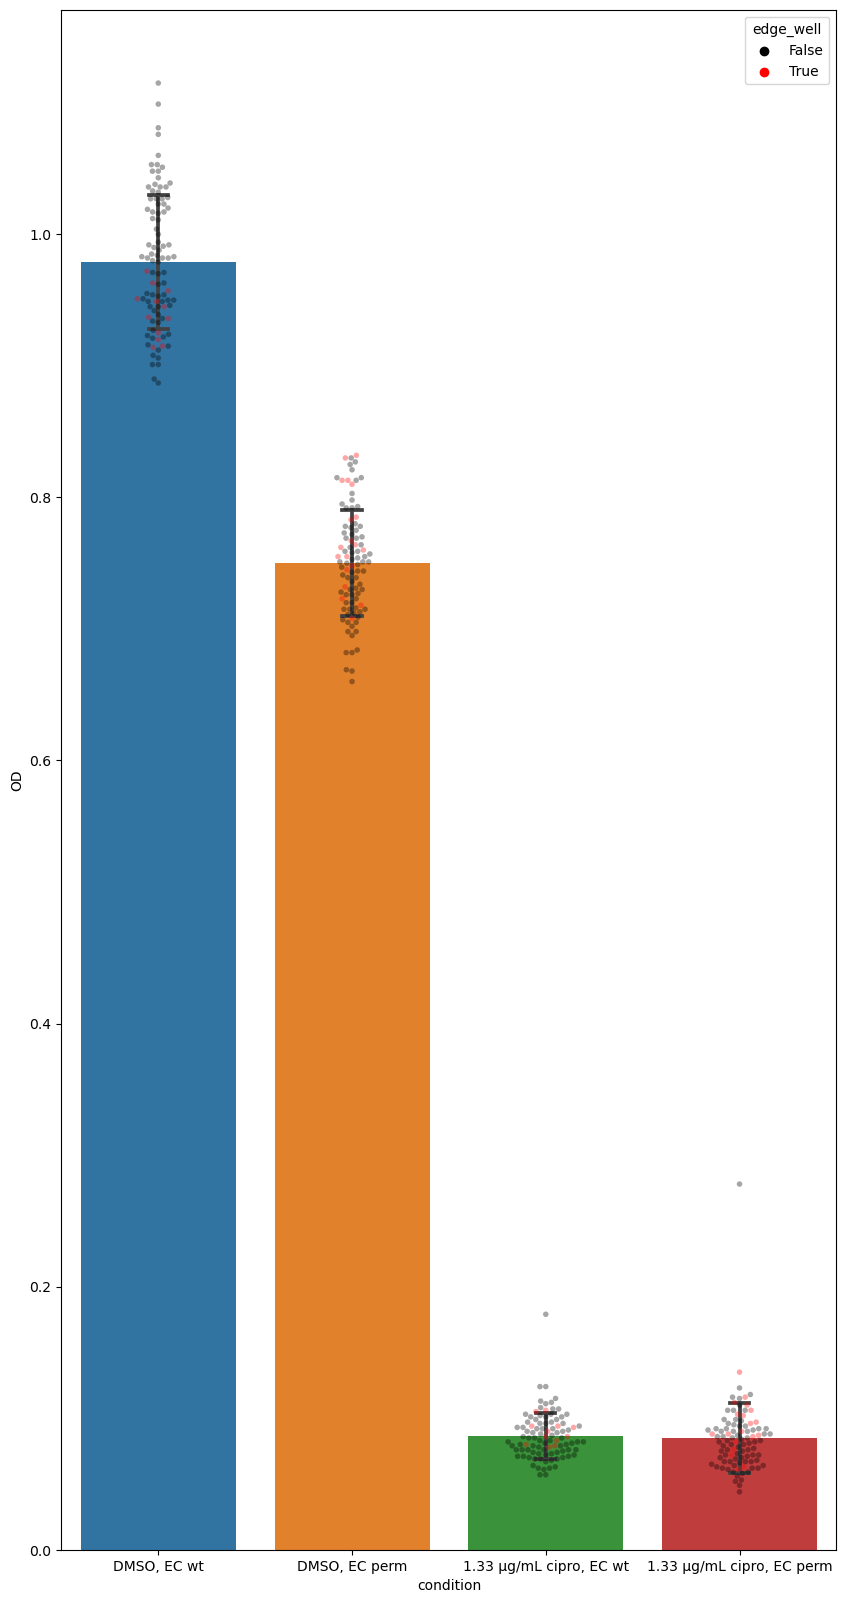

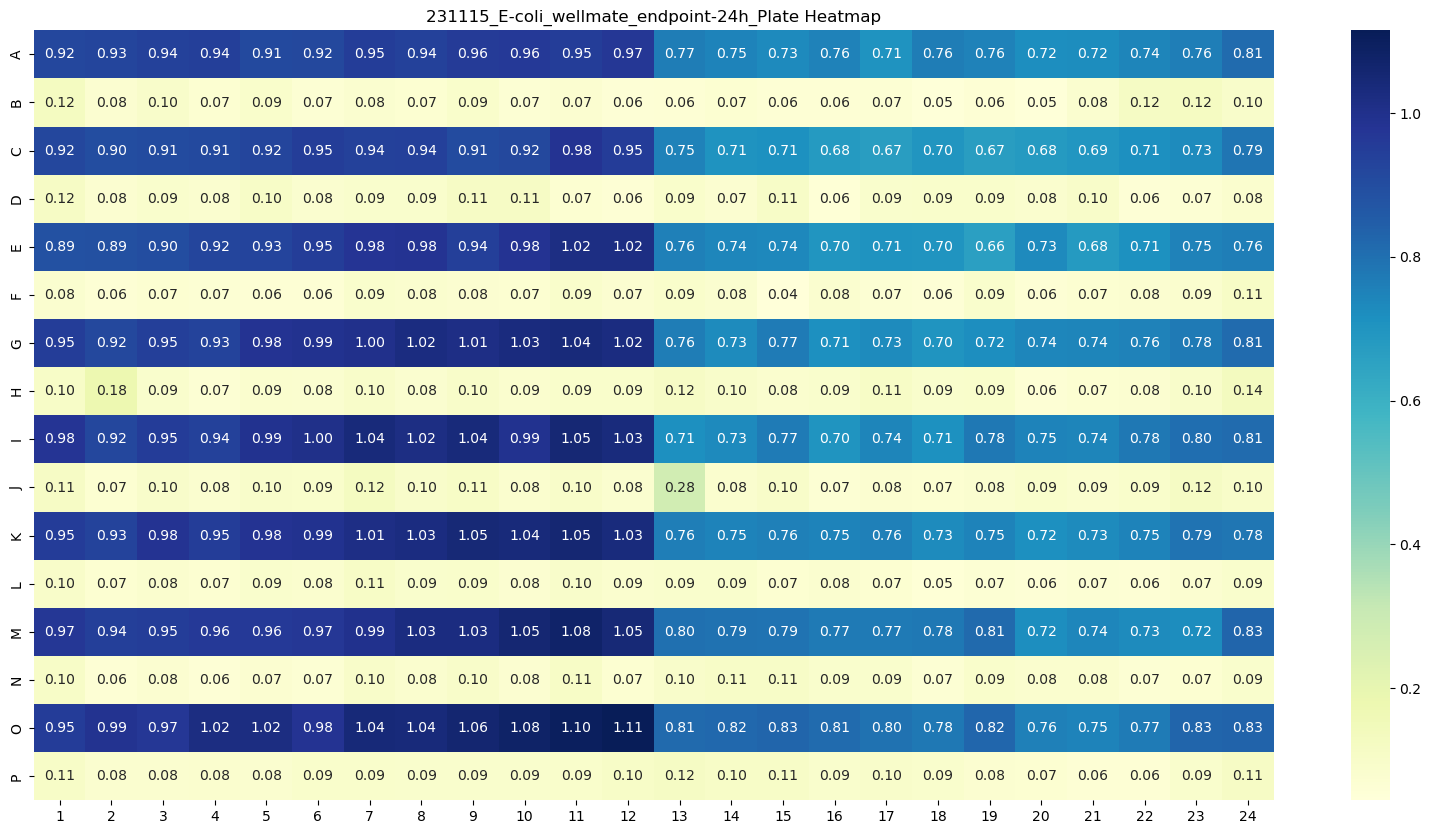

In [33]:
if __name__ == "__main__":
    main()